# Time series processing Xbox

In [1]:
import pandas as pd
import numpy as np

In [2]:

import datetime

from pmdarima import auto_arima

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from pmdarima import model_selection

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定

In [3]:
df_original = pd.read_excel("./xbox.xlsx")
df_original

,weekly,sales,xbox_views,xbox_subscribers,over_show_views,over_show_subscribers,wisp_views,wisp_subscribers,killercreeper55_views,killercreeper55_subscribers,...,dashiegames_views,dashiegames_subscribers,chooxtv_views,chooxtv_subscribers,gelli_clash_views,gelli_clash_subscribers,eystreem_views,eystreem_subscribers,skipthetutorial_views,skipthetutorial_subscribers
0,2024-06-08,58.7k,5037120,50000,13325478,10000,2353992,0,336067,0,...,3800069,10000,754004,0,-3811368,0,29241896,50000,16554587,80000
1,2024-06-15,65.3k,17449600,30000,13324295,20000,2254356,10000,343755,0,...,3274162,0,582488,0,-87904,-10000,24862294,60000,19334267,100000
2,2024-06-22,65.5k,4130078,0,12490503,20000,2475377,10000,410994,0,...,3793509,10000,704017,0,63747,0,33752206,120000,21004932,40000
3,2024-06-29,66.6k,2399020,10000,16222050,30000,2690821,0,388196,10000,...,3911438,10000,697483,0,135788,0,27981528,100000,21073549,60000
4,2024-07-06,70.8k,1157309,0,15112619,40000,2642344,10000,370312,0,...,2510458,0,663733,0,114195,0,25186224,100000,20855148,70000


In [4]:
df_x = df_original.drop(columns=["sales", "weekly"])
df = df_x.applymap(lambda x: np.log(x) if x > 0 else 0)
df["sales"] = df_original["sales"]
df["weekly"] = df_original["weekly"]

# convert the weekly column to datetime 
df['weekly'] = pd.to_datetime(df['weekly'])

# set weekly column to index
df.set_index('weekly', inplace=True)

# remove "k" from sales column
df['sales'] = df['sales'].str.replace('k', '').astype(float) * 1000

(array([19883., 19887., 19891., 19895., 19899., 19903., 19905., 19909.]),
 [Text(19883.0, 0, '2024-06-09'),
  Text(19887.0, 0, '2024-06-13'),
  Text(19891.0, 0, '2024-06-17'),
  Text(19895.0, 0, '2024-06-21'),
  Text(19899.0, 0, '2024-06-25'),
  Text(19903.0, 0, '2024-06-29'),
  Text(19905.0, 0, '2024-07-01'),
  Text(19909.0, 0, '2024-07-05')])

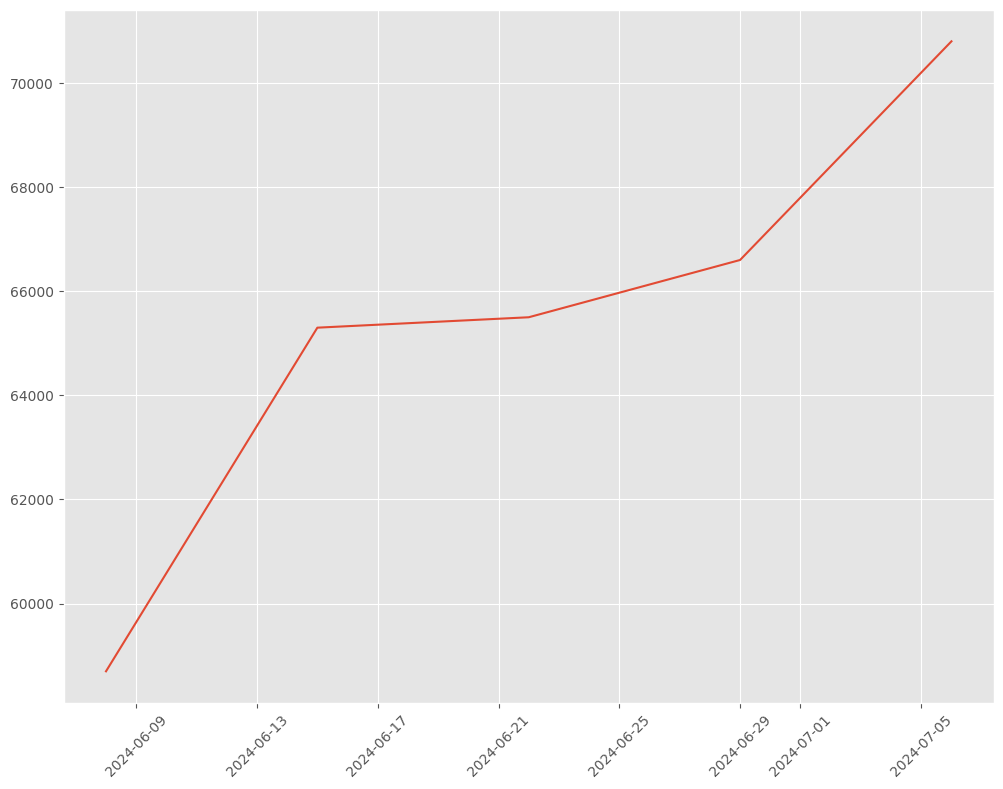

In [5]:
plt.plot(df["sales"])
plt.xticks(rotation=45)

# Data analysis SWITCH

### ARIMA

In [6]:
# making new data frame for arima model 

# reseting the index of the dataframe 
df_reset = df.reset_index()

# df_sales, newdataframe has only weekly and sales columns
df_sales = df_reset[["weekly", "sales"]]

# set weekly column as index
df_sales = df_sales.set_index("weekly")
df_sales

,sales
weekly,
2024-06-08,58700.0
2024-06-15,65300.0
2024-06-22,65500.0
2024-06-29,66600.0
2024-07-06,70800.0


In [7]:
# Split the dataset into training and test data (last 2 weeks)

from pmdarima import model_selection

# Ensure that the index is datetime
df_sales.index = pd.to_datetime(df_sales.index)

train, test = model_selection.train_test_split(df_sales, test_size=2) 

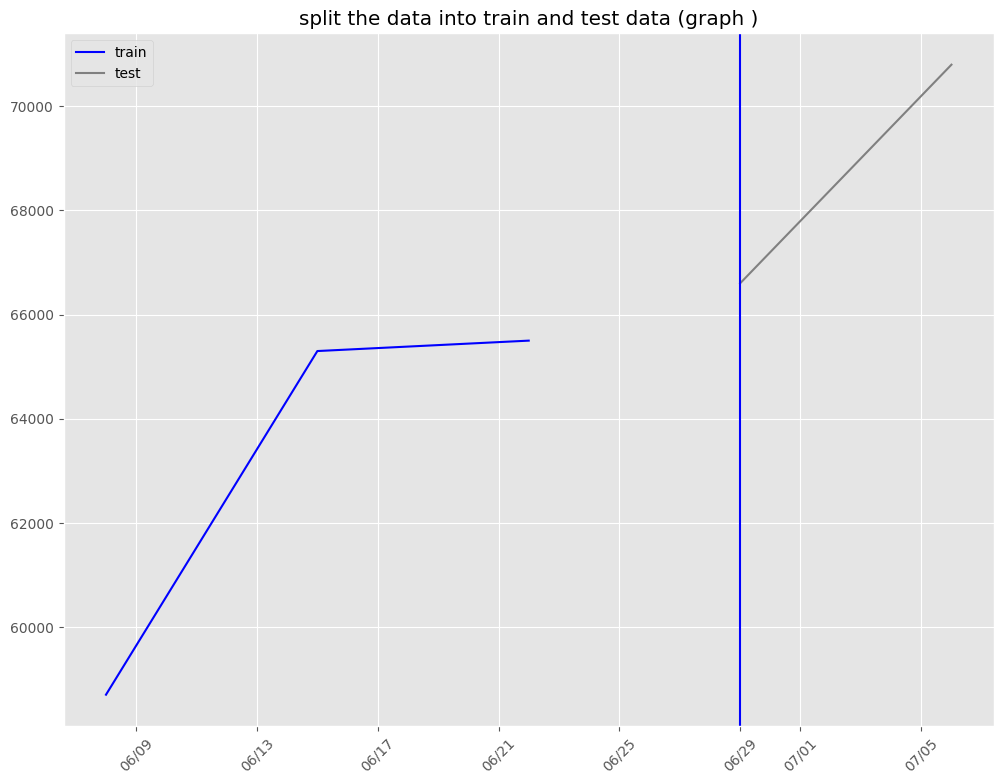

In [8]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'train' and 'test' DataFrames are already defined and have a DateTime index

fig, ax = plt.subplots()

# plot the train data
ax.plot(train.index.values, train.values, label='train', color='blue')

# plot the test data 
ax.plot(test.index.values, test.values, label='test', color='gray')

# Depiction of vertical lines between training and test data
ax.axvline(datetime.datetime(2024, 6, 29), color='blue')

# Format the x-axis to show only the month and day
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

# Rotate the x-axis labels for better readability (optional)
plt.xticks(rotation=45)


ax.legend()
plt.title("split the data into train and test data (graph )")
plt.show()


In [9]:
from pmdarima import auto_arima
# Predictive model training (using training data)

# train 
arima_model = auto_arima(train)

# result
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    3
Model:                        SARIMAX   Log Likelihood                 -28.431
Date:                Wed, 21 Aug 2024   AIC                             60.863
Time:                        20:11:29   BIC                             59.060
Sample:                    06-08-2024   HQIC                            57.239
                         - 06-22-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.317e+04   2.35e+04      2.682      0.007     1.7e+04    1.09e+05
sigma2      9.982e+06    2.1e+08      0.047      0.962   -4.02e+08    4.22e+08
Ljung-Box (L1) (Q):                   0.17   Jarque-

In [10]:
# implement the forecasting

# Prediction of study data period
train_pred = arima_model.predict_in_sample()

# Prediction of test data period
test_pred = arima_model.predict(n_periods=2)

In [11]:
# evaluation

print('RMSE:\n',np.sqrt(mean_squared_error(test.sales, test_pred)))
print('MAE:\n',mean_absolute_error(test.sales, test_pred)) 
print('MAPE:\n',mean_absolute_percentage_error(test.sales, test_pred))

RMSE:
 5918.42696818823
MAE:
 5533.3333333333285
MAPE:
 0.07968349705637834


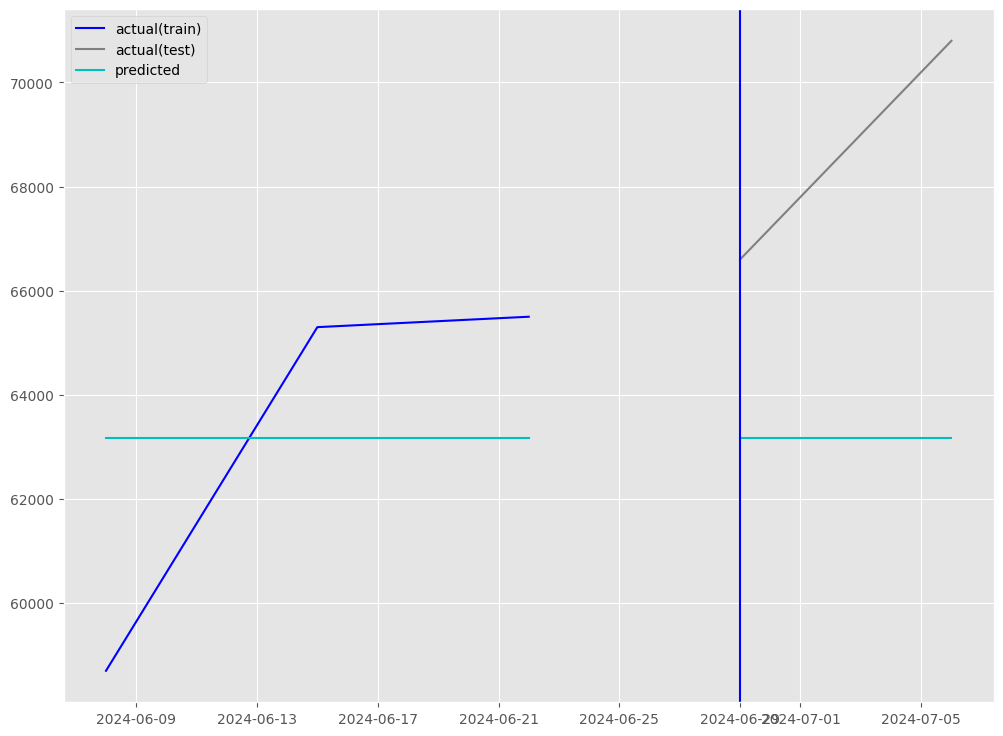

In [12]:
# plot the graph of actual and predicted values
import datetime

fig, ax = plt.subplots()

# actual value
## train
ax.plot(train.index.values, train.sales.values, label='actual(train)', color='blue')
## test
ax.plot(test.index.values, test.sales.values, label='actual(test)', color='gray')

# prediction
## train
ax.plot(train.index.values, train_pred.values, color='c')
## test
ax.plot(test.index.values, test_pred.values, label="predicted", color="c") 

# Depiction of vertical lines between training and test data
ax.axvline(datetime.datetime(2024,6,29),color='blue')

ax.legend()

plt.show()

### PCA regression 

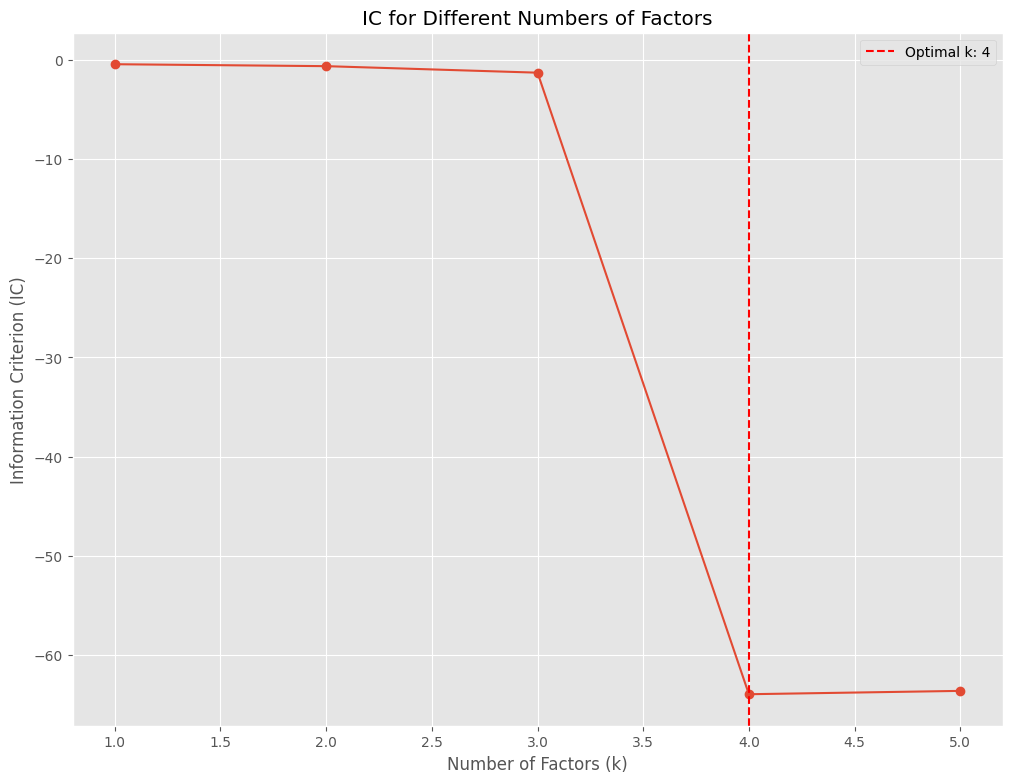

the optimal number of k: 4


In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.ar_model import AutoReg
import statsmodels.api as sm

X = df.drop("sales", axis=1)

# standardized
X_standardized = (X - X.mean()) / X.std()

# NaN is filled with 0
X_standardized = X_standardized.fillna(0)

# setting the parameters
N, T = X_standardized.shape
max_k = min(N, T, 20)  # maximum number of principal components

# the function that calculate the information criteria
def calculate_ic(X, k, N, T):
    pca = PCA(n_components=k)
    pca.fit(X)
    F = pca.transform(X)
    Lambda = pca.components_.T
    V_k = np.sum((X - F @ Lambda.T) ** 2) / (N * T)
    IC_k = np.log(V_k) + k * (N + T) / (N * T) * np.log(N * T / (N + T))
    return IC_k

# selecting the optimal number of components so that IC is minimized
ic_values = [calculate_ic(X_standardized.values, k, N, T) for k in range(1, max_k + 1)]
optimal_k = np.argmin(ic_values) + 1

# plot IC
plt.plot(range(1, max_k + 1), ic_values, marker='o')
plt.xlabel('Number of Factors (k)')
plt.ylabel('Information Criterion (IC)')
plt.title('IC for Different Numbers of Factors')
plt.axvline(optimal_k, color='r', linestyle='--', label=f'Optimal k: {optimal_k}')
plt.legend()
plt.show()

print(f"the optimal number of k: {optimal_k}")

In [14]:
# standardinzing data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# pca
pca = PCA(n_components=optimal_k)

principal_components = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(data=principal_components)
pca_df

,0,1,2,3
0,5.296830,-2.677468,1.266778,1.916938
1,2.952076,4.611359,-1.604910,-1.899466
2,-1.849020,-4.070323,-2.331640,-2.553152
3,-2.903385,0.864825,5.144895,-0.676340
4,-3.496502,1.271607,-2.475123,3.212019


In [15]:
# Split the dataset into training and test data (last 2 weeks)

pca_df["sales"] = df_original["sales"]
# remove "k" from sales column
pca_df['sales'] = df_original['sales'].str.replace('k', '').astype(float) * 1000

# convert the weekly column to datetime 
pca_df['weekly'] = pd.to_datetime(df_original['weekly'])

# set weekly column to index
pca_df.set_index('weekly', inplace=True)


# split the data into train and test data
train, test = model_selection.train_test_split(pca_df, test_size=2)

# train
y_train = train['sales']              #dependet variable y
X_train = train.drop('sales', axis=1) #independent variable X

# test
y_test = test['sales']              #dependent variable y
X_test = test.drop('sales', axis=1) #independent variable X

In [16]:
# instance
regressor = LinearRegression()

# train
regressor.fit(X_train, y_train)

# intercept and coefficients
print('intercept:',regressor.intercept_)
print('coefficients:',regressor.coef_)

intercept: 63830.34246121646
coefficients: [-537.72601785  340.64154687 -368.0254145  -471.49953775]


In [17]:
# prediction (train data)

train_pred = regressor.predict(X_train)

In [18]:
# prediction（test data）

# copy of the train data 
y_train_new = y_train.copy()

# Forecasting is performed while updating the explanatory variable X
for i in range(len(y_test)):
    
    # Implementation of forecasts for the current period
    X_value =  X_test.iloc[i:(i+1),:]
    y_value_pred = regressor.predict(X_value)
    y_value_pred = pd.Series(y_value_pred,index=[X_value.index[0]])
    y_train_new = pd.concat([y_train_new,y_value_pred])
    
    #Calculation of the explanatory variable X for the next period
    f1 = y_train_new.iloc[-1] 
    f2 = y_train_new.iloc[-1]
    f3 = y_train_new.iloc[-1]
    f4 = y_train_new.iloc[-1]
    
    #Update explanatory variable X in the next period
    X_test.iloc[(i+1):(i+2),0] = f1
    X_test.iloc[(i+1):(i+2),1] = f2
    X_test.iloc[(i+1):(i+2),2] = f3
    X_test.iloc[(i+1):(i+2),3] = f4
    
# Assignment of predicted values
test_pred = y_train_new[-2:]
    
# The updated explanatory variable X
X_test

,0,1,2,3
weekly,,,,
2024-06-29,-2.903385,0.864825,5.144895,-0.676340
2024-07-06,64111.605332,64111.605332,64111.605332,64111.605332


In [19]:
# evaluation 

print('RMSE:\n',np.sqrt(mean_squared_error(y_test, test_pred)))
print('MAE:\n',mean_absolute_error(y_test, test_pred)) 
print('MAPE:\n',mean_absolute_percentage_error(y_test, test_pred))

RMSE:
 46998321.6806563
MAE:
 33234076.13882204
MAPE:
 469.40896330108717


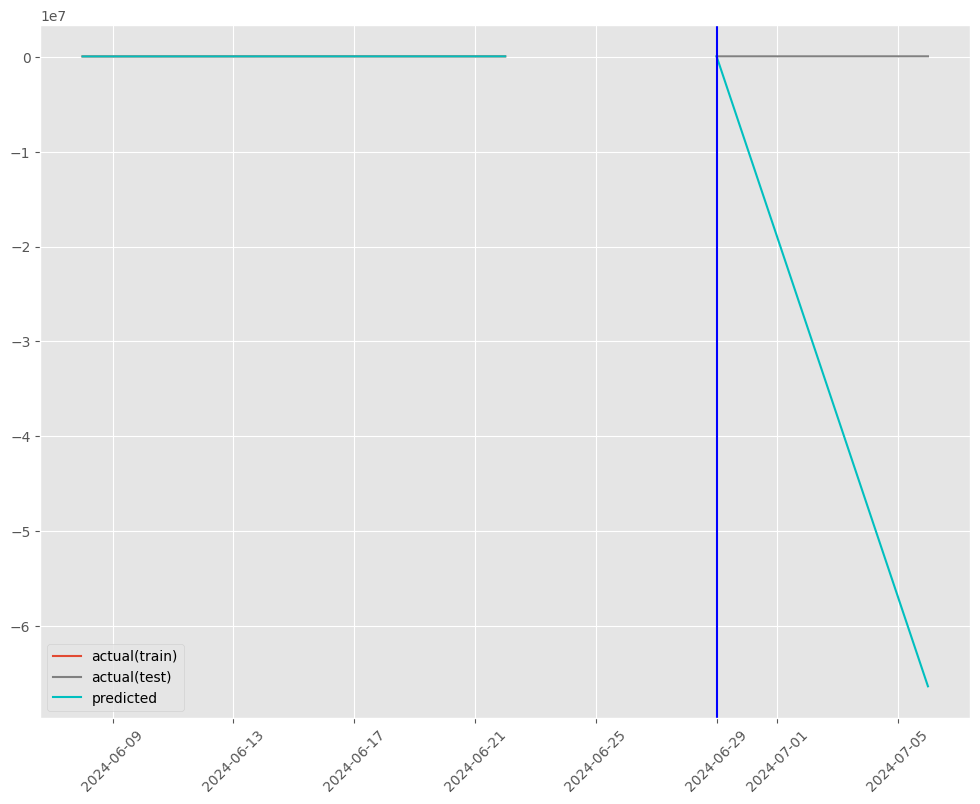

In [20]:
# plot the grapg（actual and predicted value）

import datetime
fig, ax = plt.subplots()

# actual value
## train
ax.plot(train.index, y_train, label='actual(train)')
## test
ax.plot(test.index, y_test, label='actual(test)', color='gray')

# predicted value
## train
ax.plot(train.index, train_pred, color='c')
## test
ax.plot(test.index, test_pred, label="predicted", color="c") 

# Depiction of vertical lines between training and test data
ax.axvline(datetime.datetime(2024,6,29),color='blue')

ax.legend()

plt.xticks(rotation=45)
plt.show()

### Ridge

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Preprocessing sales data: remove 'k' and convert to numeric
#df['sales'] = df['sales'].str.replace('k', '').astype(float) * 1000

# Select features (all columns from C onward) and target ('sales')
X = df.iloc[:, 2:]  # All columns except 'weekly' and 'sales'
y = df['sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Fit the Ridge regression model
ridge = Ridge(alpha=1.0)  # You can adjust the alpha parameter for regularization strength
ridge.fit(X_train, y_train)

# Make predictions
y_pred = ridge.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

rmse, mae, mape, y_pred[:5]  # Show the RMSE, MAE, MAPE and first few predictions


(0.03935475734835449,
 0.03709047973097768,
 5.381132705920212e-07,
 array([65299.97606601, 70799.94975303]))

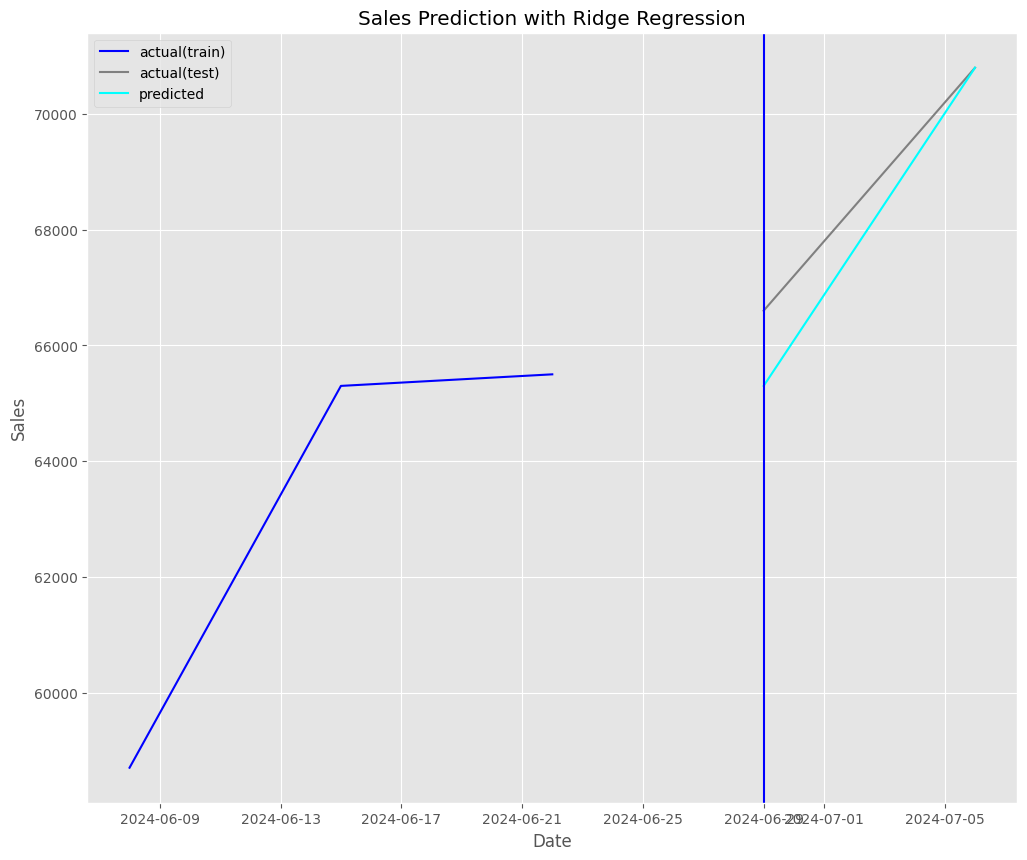

In [22]:
import matplotlib.pyplot as plt

# Split the original data to distinguish between train and test sets
train_size = int(len(y) * 0.6)
train_index = df.index[:train_size]
test_index = df.index[train_size:]

# Plotting the data
plt.figure(figsize=(12, 10))

# Actual train data
plt.plot(train_index, y[:train_size], color='blue', label='actual(train)')

# Actual test data
plt.plot(test_index, y[train_size:], color='gray', label='actual(test)')

# Predicted test data
plt.plot(test_index, y_pred, color='cyan', label='predicted')

# Vertical line to separate train and test
plt.axvline(x=test_index[0], color='blue')

# Adding labels and legend
plt.legend()
plt.title('Sales Prediction with Ridge Regression')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


Lasso

RMSE: 2939.469569616893
MAE: 2363.5890156790047
MAPE: 0.03375045901380868
First 5 Predictions: [64683.96021558 66688.86175306]


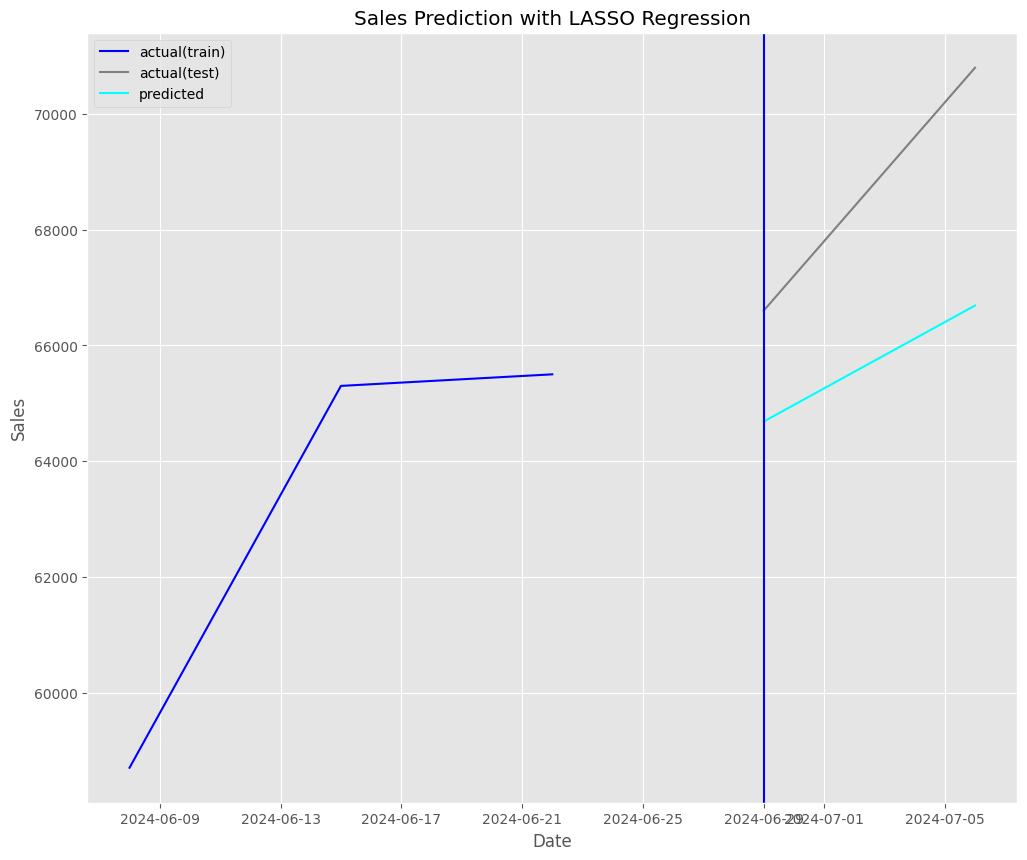

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing sales data: remove 'k' and convert to numeric (必要に応じて)
# df['sales'] = df['sales'].str.replace('k', '').astype(float) * 1000

# Select features (all columns from C onward) and target ('sales')
X = df.iloc[:, 2:]  # All columns except 'weekly' and 'sales'
y = df['sales']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Fit the LASSO regression model
lasso = Lasso(alpha=1.0)  # You can adjust the alpha parameter for regularization strength
lasso.fit(X_train, y_train)

# Make predictions
y_pred = lasso.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)
print("First 5 Predictions:", y_pred[:5])

# Split the original data to distinguish between train and test sets
train_size = int(len(y) * 0.6)
train_index = df.index[:train_size]
test_index = df.index[train_size:]

# Plotting the data
plt.figure(figsize=(12, 10))

# Actual train data
plt.plot(train_index, y[:train_size], color='blue', label='actual(train)')

# Actual test data
plt.plot(test_index, y[train_size:], color='gray', label='actual(test)')

# Predicted test data
plt.plot(test_index, y_pred, color='cyan', label='predicted')

# Vertical line to separate train and test
plt.axvline(x=test_index[0], color='blue')

# Adding labels and legend
plt.legend()
plt.title('Sales Prediction with LASSO Regression')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()
